# Introduction

This notebook functions as my journal for experiments with BNNs. The goal is to understand intuitively how they work on the data applied to them, understand how they quantify uncertainty, propose ways to improve performance, suggest architecture recommendations and just play with them when all is said and done.

What I know about BNNs I largely know due to this [tutorial/review paper](https://arxiv.org/pdf/2007.06823). Querying LLMs like Claude, Qwen and Le Chat comes in useful when notation gets terse.

# Setup

In [1]:
!pip install numpyro
!pip install ipywidgets
!pip install --upgrade pip
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.1/351.1 kB 9.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


In [2]:
%env NotebookApp.iopub_msg_rate_limit=10000

env: NotebookApp.iopub_msg_rate_limit=10000


In [3]:
import argparse
import os
import time

import wandb
import math

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap, random, devices
import jax.numpy as jnp
import jax

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import tensorflow_datasets as tfds

In [4]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Initialize wandb
wandb.init(project="bnn-mnist")

wandb: Currently logged in as: gyamfisamuel10. Use `wandb login --relogin` to force relogin


# Data Preprocessing

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Train images shape: (1000, 784), Train labels shape: (1000,)
Test images shape: (400, 784), Test labels shape: (400,)


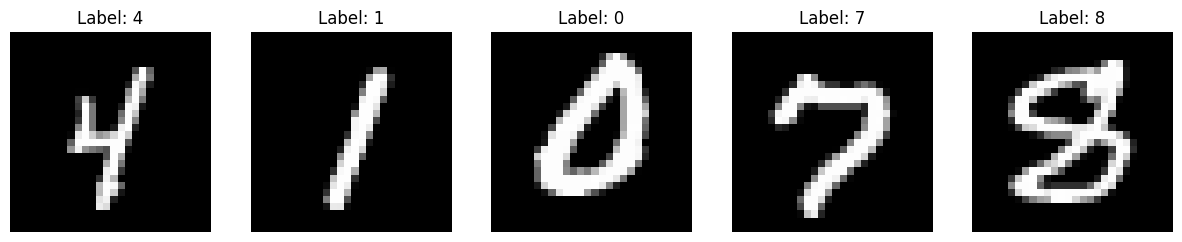

In [6]:
def load_mnist(batch_size=5, train_subset_size=300, test_subset_size=700):
    train_ds = tfds.load('mnist', split='train', batch_size=batch_size, as_supervised=True)
    test_ds = tfds.load('mnist', split='test', batch_size=batch_size, as_supervised=True)

    # Convert the training dataset to a list of tuples and then to NumPy arrays
    train_images = []
    train_labels = []
    for batch in train_ds.take(train_subset_size // batch_size):
        images, labels = batch
        train_images.append(images.numpy().astype(np.float32) / 255.0)
        train_labels.append(labels.numpy())

    train_images = np.concatenate(train_images, axis=0).reshape(-1, 28 * 28)
    train_labels = np.concatenate(train_labels, axis=0)

    # Convert the test dataset to a list of tuples and then to NumPy arrays
    test_images = []
    test_labels = []
    for batch in test_ds.take(test_subset_size // batch_size):
        images, labels = batch
        test_images.append(images.numpy().astype(np.float32) / 255.0)
        test_labels.append(labels.numpy())

    test_images = np.concatenate(test_images, axis=0).reshape(-1, 28 * 28)
    test_labels = np.concatenate(test_labels, axis=0)

    return (train_images, train_labels), (test_images, test_labels)

(train_images, train_labels), (test_images, test_labels) = load_mnist(batch_size=5, train_subset_size=1000, test_subset_size=400)
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

# Visualize some sample data
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {train_labels[i]}")
    ax.axis('off')
plt.show()

# Model Definition

In [7]:
def nonlin(x):
  return jax.nn.softmax(x)

# Bayesian Neural Network definition
def model(X, Y, D_H, D_Y=10):
  N, D_X = X.shape

  # Sample the weights connecting the input layer to the first hidden layer
  w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))
  assert w1.shape == (D_X, D_H)

  # Apply an activation function on the matrix multiplication of the weights and their inputs
  z1 = nonlin(jnp.matmul(X, w1))
  assert z1.shape == (N, D_H)

  # Sample the weights connecting the first hidden layer to the output layer
  w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))
  assert w2.shape == (D_H, D_Y)
  logits = jnp.matmul(z1, w2)
  assert logits.shape == (N, D_Y)

  # Likelihood
  numpyro.sample("obs", dist.Categorical(logits=logits), obs=Y)


# Inference and prediction

In [8]:
# Choose different inference technique.
def run_inference(model, args, rng_key, X, Y, D_H):
  print("Running inference")
  start = time.time()
  kernel = NUTS(model)
  mcmc = MCMC(
      kernel,
      num_warmup=args.num_warmup,
      num_samples=args.num_samples,
      num_chains=args.num_chains,
      progress_bar=False, 
      chain_method='parallel'
  )

  # Run the MCMC sampler on the entire dataset
  mcmc.run(rng_key, X, Y, D_H)

  mcmc.print_summary()
  print("\nMCMC elapsed time:", time.time() - start)
  return mcmc.get_samples()

def predict(model, rng_key, samples, X, D_H):
  model = handlers.substitute(handlers.seed(model, rng_key), samples)
  model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
  return model_trace["obs"]["value"]


# Evaluation

In [11]:
def evaluate_model(args):
  (train_images, train_labels), (test_images, test_labels) = load_mnist(batch_size=5, train_subset_size=400, test_subset_size=600)

  rng_key, rng_key_predict = random.split(random.PRNGKey(0))
  samples = run_inference(model, args, rng_key, train_images, train_labels, args.num_hidden)

  vmap_args = (
      samples,
      random.split(rng_key_predict, args.num_samples * args.num_chains),
  )

  print("Batching the test data")
  batch_size = 5
  num_batches = len(test_images) // batch_size
  predictions = []

  for i in range(num_batches):
    batch_start = i * batch_size
    batch_end = (i + 1) * batch_size
    batch_X = test_images[batch_start:batch_end]

    batch_predictions = vmap(
        lambda samples, rng_key: predict(model, rng_key, samples, batch_X, args.num_hidden)
    )(*vmap_args)

    predictions.append(batch_predictions)

  predictions = jnp.concatenate(predictions, axis=1)
  median_prediction = jnp.median(predictions, axis=0)
  #predicted_labels = jnp.round(mean_prediction).astype(int)
  predicted_labels = median_prediction.astype(int)

  # Debugging shapes
  print(f"Predictions shape: {predictions.shape}")
  print(f"Mean prediction shape: {median_prediction.shape}")
  print(f"Test labels shape: {test_labels.shape}")
  print(f"View of what the predictions look like: {predicted_labels}")
  print(f"View of what the Test labels look like: {test_labels}")

  # Ensure the shapes are correct
  assert median_prediction.shape[0] == test_labels.shape[0]

  # Evaluate accuracy
  print("Evaluating the accuracy")
  accuracy = jnp.mean(predicted_labels == test_labels)
  print(f"Test accuracy: {accuracy:.4f}")

  # Log accuracy to wandb
  wandb.log({"test_accuracy": accuracy})

  # Visualize some predictions
  print("Visualizing the predictions")
  fig, axes = plt.subplots(3, 3, figsize=(10, 10))
  axes = axes.flatten()

  for i in range(9):
    image = test_images[i].reshape(28, 28)
    true_label = test_labels[i]
    pred_label = predicted_labels[i]
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"True: {true_label}, Pred: {pred_label}")
    axes[i].axis('off')

  plt.show()

  # Log images to wandb
  wandb.log({"predictions": [wandb.Image(fig, caption=f"Predictions vs True Labels")]})

# Experimentation and Logging

Running inference

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   w1[0,0]      0.00      0.95      0.02     -1.43      1.69   2027.77      1.00
   w1[0,1]      0.01      0.99      0.00     -1.69      1.56   1381.77      1.00
   w1[0,2]     -0.03      1.02     -0.04     -1.68      1.62   2292.53      1.00
   w1[0,3]     -0.01      1.06     -0.00     -1.54      1.83   2128.60      1.00
   w1[0,4]      0.03      1.02      0.03     -1.69      1.61   2594.84      1.00
   w1[0,5]      0.03      0.99      0.02     -1.69      1.57   1525.79      1.00
   w1[0,6]     -0.02      1.00     -0.02     -1.65      1.52   2268.54      1.00
   w1[0,7]     -0.02      1.02     -0.03     -1.82      1.57   1550.14      1.00
   w1[0,8]     -0.02      1.00      0.00     -1.80      1.50   2677.96      1.00
   w1[0,9]     -0.04      0.99     -0.04     -1.67      1.55   1854.78      1.00
  w1[0,10]      0.00      0.97     -0.01     -1.50      1.58   1995.91      1.00
  w1[0,11

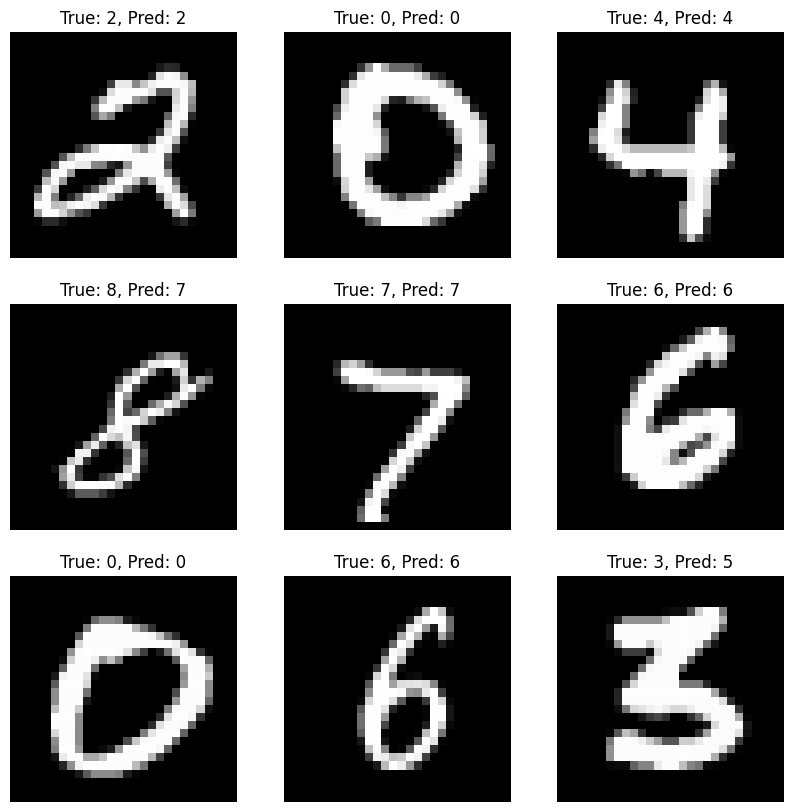

In [12]:
class Args:
  def __init__(self, num_samples, num_warmup, num_chains, num_hidden, device):
      self.num_samples = num_samples
      self.num_warmup = num_warmup
      self.num_chains = num_chains
      self.num_hidden = num_hidden
      self.device = device

# Baseline configuration
args = Args(num_samples=500, num_warmup=500, num_chains=2, num_hidden=30, device="gpu")
numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)

# Run baseline evaluation
evaluate_model(args)

## Using BNNs in Predict then Optimize scenarios
As a way to deal with lack of expert knowledge when setting parameters for optimization problems, the Predict then Optimize and Smart Predict then Optimize approaches have arisen as great ways to determine the weights.

Most of the time these weights are formulated with basic ANNs. I think it'd be interesting to see how well BNNs perform in predict then optimize type scenarios.

## Dynamic Learning in BNNs
The human brain isn't static. It's highly dynamic with rate of learning strongly tied to neurogenesis. Inspired by the work of Sutton et al, could we implement dynamic learning in a Bayesian manner?

### Algorithm Outline:

####  Initialization
Initialize the BNN with a base architecture (e.g., a single hidden layer).
Define hyperparameters such as learning rate, number of initial units, and thresholds for layer growth.

#### Online Learning:
Use a streaming or mini-batch approach to process incoming data.
Update the weights using a Bayesian inference method (e.g., variational inference or MCMC).

#### Similarity Measurement:
Define a similarity metric to compare new information with existing information in the network.
Use this metric to decide whether to grow the network by adding new layers or units. We could also just use entropy as a measure of surprise here and see how well that performs.

#### Dynamic Layer Growth:
If the similarity metric indicates that new information is significantly different from existing information, add a new layer.
Initialize the new layer with weights that capture the new information.

#### Weight Growth:
Allow the weights to grow by adding new units to existing layers if the new information is somewhat similar to existing information but requires additional capacity.

#### Regularization:
Implement regularization techniques to prevent overfitting and ensure that the network generalizes well.